# Prepare Data

We are going to work with the News Category Dataset from Kaggle:

https://www.kaggle.com/rmisra/news-category-dataset

The data is already present inside the repository in a zipped format. Please unzip it first in order to proceed with the notebook.

# Analysis

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import random
import spacy

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.utils.extmath import randomized_svd

In [4]:
# NLTK Imports
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet

Initialize and download some global stuff related to NLP:

In [5]:
nltk.download('stopwords')
nltk.download("wordnet")
nltk.download('averaged_perceptron_tagger')

lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')

# Initialize spacy 'en' model, keeping only tagger component needed for lemmatization 
spacy_nlp = spacy.load('en', disable=['parser', 'ner'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [6]:
# Random seed in case we'll need to pass one to some function
RANDOM_SEED = 42

In [7]:
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

## Data Preparation

### Loading

In [8]:
# Load dataframe
df = pd.read_json('News_Category_Dataset_v2.json', lines = True)
# Merge headline and description into a single text.
df["content"] = df.apply(lambda row: row["headline"]+". "+row["short_description"], axis=1)
# Remove the unnecessary columns
df = df.drop(columns=["authors", "link", "date", "headline", "short_description"])
print(f"Loaded {len(df)} samples.")

Loaded 200853 samples.


In [9]:
n_categories = len(df["category"].unique())
print(f"There are {n_categories} unique categories.")

There are 41 unique categories.


### Classes visualization

In [10]:
def visualize_classes_distrib(counts_df):
    plt.figure();
    counts_df.plot.bar(figsize=(18, 8), title="Total class counts")

POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
TRAVEL             9887
STYLE & BEAUTY     9649
PARENTING          8677
HEALTHY LIVING     6694
QUEER VOICES       6314
FOOD & DRINK       6226
BUSINESS           5937
COMEDY             5175
SPORTS             4884
BLACK VOICES       4528
HOME & LIVING      4195
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3651
WOMEN              3490
IMPACT             3459
DIVORCE            3426
CRIME              3405
MEDIA              2815
WEIRD NEWS         2670
GREEN              2622
WORLDPOST          2579
RELIGION           2556
STYLE              2254
SCIENCE            2178
WORLD NEWS         2177
TASTE              2096
TECH               2082
MONEY              1707
ARTS               1509
FIFTY              1401
GOOD NEWS          1398
ARTS & CULTURE     1339
ENVIRONMENT        1323
COLLEGE            1144
LATINO VOICES      1129
CULTURE & ARTS     1030
EDUCATION          1004
Name: category, 

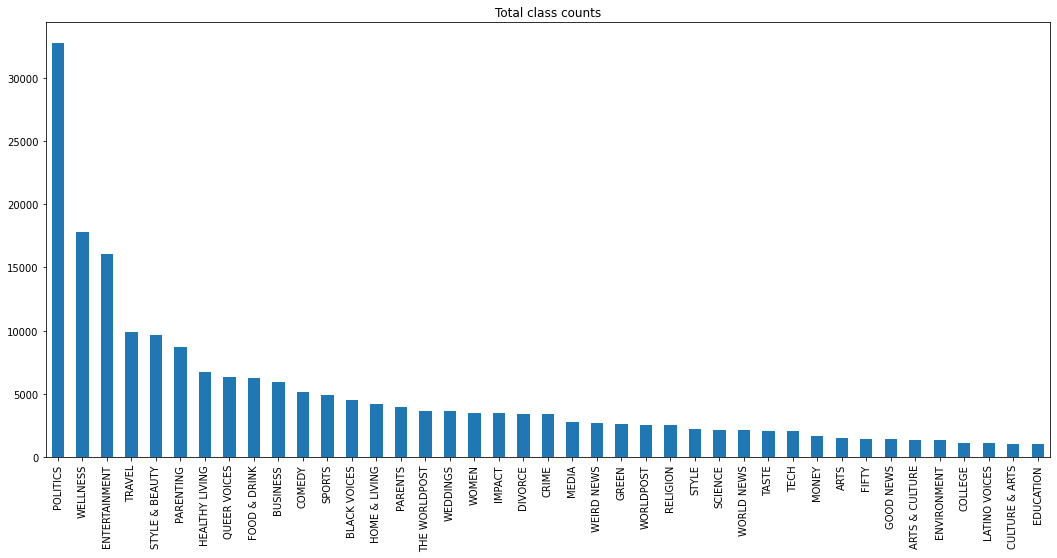

In [11]:
counts_df = df["category"].value_counts()
visualize_classes_distrib(counts_df)
print(counts_df)

The datasets seem to be imbalanced towards politics, wellness and entratainment news.

**Note**: Since the dataset covers a span between 2012 and 2018, it might include also a huge amount of election related news (probably inside the politics category) due to two elections in that time span. We might need to remove some names or concepts in the modeling part, to avoid bias towards that topic.

In [12]:
df.head(5)

,category,content
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 5...
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...


## Preprocess data

Let us start our data preprocessing process by removing punctuations and numbers, leaving only the alphabetical characters:

In [13]:
df['clean_content'] = df['content'].str.replace("[^a-zA-Z#]", " ")

Then we would like to lowercase all of our text samples:

In [14]:
df['clean_content'] = df['clean_content'].str.lower()

Remove stopwords by tokenization, filtering and joining back together our text, also remove too short words (less than 3 chars):

In [15]:
df['clean_content'] = df['clean_content'].str.split()
df['clean_content'] = df['clean_content'].apply(lambda text: " ".join([
    word for word in text if word not in stop_words and len(word) > 3
]))

Then transform each text into a set of unique words:

In [16]:
df['clean_content'] = df['clean_content'].apply(lambda text: " ".join(set(text.split())))

Perform a lemmatization of each unique word:

**WARNING**: VERY SLOW CELL (takes like 10min)

In [17]:
# Avoid running a lemmatization, 
# as the results without it already seem to be acceptable
do_lemmatize = False
if do_lemmatize:
    df['clean_content'] = df['clean_content'].apply(lambda text: " ".join(set(
        [token.lemma_ for token in spacy_nlp(text)])
    ))

Finally, let's visualize a sample of the preprocessed data

In [18]:
df['clean_content'].head(10)

0    killed mass shootings children another texas l...
1    official smith diplo world course song nicky j...
2    time actor grant knot hugh longtime girlfriend...
3    castrato actor schiff blasts enough fighting t...
4    using actress julianna bags uses cathartic tru...
5    undermine freeman devastated claims sexual hor...
6    lovin tonight catchy show trump right jingle m...
7    watch prime mini great amazon week joining series
8    mike like powers fourth pushing austin film ki...
9    watch winning award hulu week movie getting ac...
Name: clean_content, dtype: object

As we can see, each document is now represented as a set of filtered words.

## Modeling

### TF-IDF model

First we'll define a list of stop words, then we'll define a TF-IDF model instance.

In [19]:
# Define a list of excluded words: stop words + some domain and too common verbs and words
ext_stop_words = stop_words + [
       "donald", "trump", "hillary", "clinton", "barrack", "obama", "bernie", "sanders", 
       "be", "want", "like", "have", "go", "say", "make", "take", "see", "look", "ask", "love",
       "would", "could", "should"
]

# Define the TF-IDF model instance
vectorizer = TfidfVectorizer(
    stop_words=ext_stop_words, 
    use_idf=True,
    min_df=5, 
    #max_df=0.7,
    max_features=10000, 
    ngram_range=(1, 3),
)

Then we'll compute the actual TF-IDF matrix, obtaining a document-term matrix.

In [20]:
# Returns document-term matrix
X = vectorizer.fit_transform(df['clean_content'])
X_term_doc = X.T

In [21]:
terms_vocabulary = vectorizer.get_feature_names()
terms_vocabulary_arr = np.array(terms_vocabulary)

In [22]:
print(f"Documents-terms matrix shape: {X.shape}")
print(f"Terms-documents matrix shape: {X_term_doc.shape}")

Documents-terms matrix shape: (200853, 10000)
Terms-documents matrix shape: (10000, 200853)


### SVD and LSA

Let us first define a number of topics that we want to extract from the term-doc matrix, and then use an SVD decomposition algorithm to obtain the decomposed components.

**Note**: We'll use a smaller number of topics than the available classes in the dataset (41), because we would like to find topics that are inter-class.

**Note for prof**: I've to increase a bit more the number of topics, but the results did start getting worse at around 15 topics and more.

In [23]:
NUM_TOPICS = 10

U, S, VT = randomized_svd(X_term_doc, n_components=NUM_TOPICS, n_iter='auto', random_state=RANDOM_SEED)

In our case, the SVD decomposition of term-doc matrix will be composed of the following terms:
- **U**: Word similarity matrix by topic
- **S**: Topic strength/variability
- **VT**: Document similarity matrix by topic



Let us now visualize the strength/variability for each topic:

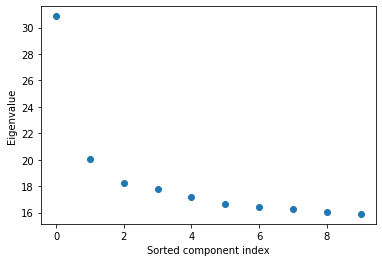

In [24]:
plt.plot(sorted(S, reverse=True), 'o')
plt.ylabel("Eigenvalue")
plt.xlabel("Sorted component index")
plt.show()

Compute terms latent space and documents latent space matrices:

In [25]:
# mathematically, we're using the topic scores (score of each latent dimension) 
# to rescale each latent dimension (related to the topic) inside each document.
docs_latent_space = np.diag(S) @ VT

# mathematically, we're using topic scores to rescale each latent dimension
# (related to topic) inside each
terms_latent_space = U @ np.diag(S)

print(f"Shape of latent docs space: {docs_latent_space.shape}")
print(f"Shape of latent terms space: {terms_latent_space.shape}")

Shape of latent docs space: (10, 200853)
Shape of latent terms space: (10000, 10)


In [26]:
TOP_N_DOCS = 15
TOP_N_TERMS = 10

Let us inspect for each of the computed topic, a top N of highest scoring documents inside that topic.

In [27]:
n_documents = X_term_doc.shape[1]
# most similar docs for each topic
for i, latent_component in enumerate(docs_latent_space):
    # latent component here will indicate for current topic, the document score for each document.
    doc_idx_comp = zip(np.arange(n_documents, step=1), latent_component)
    # for the current topic, take TOP_N_DOCS most similar docs
    sorted_docs = sorted(doc_idx_comp, key=lambda x:x[1], reverse=True)[:TOP_N_DOCS]
    print(f"Topic {i + 1}:")
    for doc_idx, score in sorted_docs:
        doc_entry = df.iloc[doc_idx]
        print(f"\t[{score:.6f}] [{doc_entry['category']}] - {doc_entry['content']}")

Topic 1:
	[0.215308] [PARENTS] - A New Kind Of Valentine's Day. I want you to learn another way to feel love in the world. It doesn't just have to come from the people you already have in your life. There are always people in the world who are alone or having a hard time who could use a smile in their day and you have the power to give that to them.
	[0.209194] [PARENTS] - Graduates, Take Your Time. I have so many things I still need to teach you about how to be the amazing person I know you can be. You're already becoming her, and watching you turn into that woman you'll soon be each and every day has been the highlight of my life for the last 18 years.
	[0.208504] [FIFTY] - Why Groupon Makes Gift-Giving Something Of A Joke. Some people think Mother's Day has become too commercial, and there are always those cranks around still harping on the US lagging behind other developed countries in providing high quality early child care, don't get them started on paid maternal leave or unequal

We can notice that the documents within each topic have common properties, and each topic is related to some abstract concept, which is what we wanted to see.

The original article category is also shown to highlight the fact that each topic includes multiple different categories revolving around the same concept.

In particular it is visible that some of the general topics are: 
- Family/persona.
- Fashion
- US Elections
- Photo compilations
- Video (e.g. "watch this video" articles)
- News related to the concept of time (e.g. first time)
- News related to the concept of year 
- Abstract concept of "people"

Let us also visualize for each topic, the top N highest scoring terms:

In [28]:
for i, latent_component in enumerate(terms_latent_space.T):
    terms_comp = zip(terms_vocabulary, latent_component)
    sorted_terms = sorted(terms_comp, key=lambda x:x[1], reverse=True)[:TOP_N_TERMS]
    terms_str = ",".join([term[0] for term in sorted_terms])
    print(f"Topic {i + 1}: {terms_str}")

Topic 1: time,people,photos,year,life,know,world,first,best,things
Topic 2: photos,check,twitter,style,facebook,huffpost,pinterest,sure,tumblr,best
Topic 3: says,president,said,house,white,state,twitter,former,women,bill
Topic 4: people,know,twitter,facebook,huffpost,check,need,pinterest,sure,tumblr
Topic 5: time,year,first,twitter,facebook,huffpost,check,video,pinterest,sure
Topic 6: people,year,world,many,years,around,last,twitter,facebook,check
Topic 7: year,know,video,last,best,kids,watch,police,things,school
Topic 8: world,life,women,around,kids,children,video,change,watch,week
Topic 9: best,know,world,time,need,year,president,america,huffpost,twitter
Topic 10: video,know,people,watch,world,first,show,star,game,ever


The top terms for each topic seem to be a bit too "vague" and shared across multiple topics, however in some form they do reflect the findings inside the documents.

### Visualization

In [29]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

In [30]:
def visualize_terms(terms_latent_space, vocabulary_array, start_dim=1, norm_threshold=0.0):
    # compute terms norms in latent space
    term_norms = np.linalg.norm(terms_latent_space, axis=1, ord=2)
    # filter the terms based on the norm
    freq_terms = term_norms > norm_threshold
    plot_dict = vocabulary_array[freq_terms]
    # select two coordinates based on start_dim
    plot_x = terms_latent_space[freq_terms, start_dim]
    plot_y = terms_latent_space[freq_terms, start_dim+1]
    # for better visualization, convert them to polar coordinates
    radius_term, angle_term = cart2pol(plot_x, plot_y)
    angle_term = np.degrees(angle_term)
    # define a new pandas dataframe for easier plotting
    plot_df_terms = pd.DataFrame({"x": plot_x, "y": plot_y, "radius": radius_term, "angle": angle_term, "term": plot_dict})
    # plot
    fig = px.scatter_polar(
        plot_df_terms, r="radius", theta="angle", hover_data=["term"],
        width=800, height=800
        )
    fig.update_layout(title_text="Thresholded terms (norm > {0}) at latent dimensions {1} to {2}".format(norm_threshold, start_dim, start_dim+1), title_x=0.5)
    fig.show()

In [31]:
def visualize_docs(docs_latent_space, category_array, description_array, start_dim=1, norm_threshold=0.0):
    # convert to numpy arrays for easier indexing
    category_array = np.array(category_array)
    description_array = np.array(description_array)
    # compute docs norms in latent space
    doc_norms = np.linalg.norm(docs_latent_space, axis=1, ord=2)
    # filter the docs based on the norm
    freq_docs = doc_norms > norm_threshold
    plot_category = category_array[freq_docs]
    plot_text = description_array[freq_docs]
    # select two coordinates based on start_dim
    plot_x = docs_latent_space[freq_docs, start_dim]
    plot_y = docs_latent_space[freq_docs, start_dim+1]
    # for better visualization, convert them to polar coordinates
    radius_doc, angle_doc = cart2pol(plot_x, plot_y)
    angle_doc = np.degrees(angle_doc)
    # define a new pandas dataframe for easier plotting
    plot_df_doc = pd.DataFrame({"x": plot_x, "y": plot_y, "radius": radius_doc, "angle": angle_doc, "category": plot_category, "text": plot_text})
    # plot
    fig = px.scatter_polar(
        plot_df_doc, r="radius", theta="angle", hover_data=["category", "text"],
        color="category",
        width=800, height=800
        )
    fig.update_layout(title_text="Thresholded documents (norm > {0}) at latent dimensions {1} to {2}".format(norm_threshold, start_dim, start_dim+1), title_x=0.5)
    fig.show()

We'll first visualize specific dimensions of the thresholded terms (to not clutter the plot):

In [32]:
visualize_terms(terms_latent_space, terms_vocabulary_arr, start_dim=1, norm_threshold=1.5)

Then we'll visualize specific dimensions of the thresholded documents:

In [33]:
visualize_docs(docs_latent_space.T, df["category"].tolist(), df["clean_content"].tolist(), start_dim=0, norm_threshold=0.5)

The plots do seem to reflect the property that we've described previously, of similar documents and terms being closeby.

Also, the document-term plot (on the same figure) is omitted, as we've seen that multiple terms are generally shared among multiple topics, so it wouldn't make sense to visualize them together.

### Experiment with Feature selection

Let us also repeat the same study for the case in which we first run a feature selection procedure to select a smaller subset of more relevant terms for each category. Only then, on the selected features, we apply the SVD decomposition and LSA.

Given the previously computed TF-IDF doc-terms matrix, we want to run a chi-squared test to select the most relevant features given their category.

Doing so, we expect to weed out the terms that are independent of their article category.

In [34]:
n_select = 5000
chi_squared_best_selector = SelectKBest(chi2, k = n_select)
X_feat_selected = chi_squared_best_selector.fit_transform(X, df['category']) 

In [35]:
print(f"Shape of {n_select} selected features doc-term matrix: {X_feat_selected.shape}")

Shape of 5000 selected features doc-term matrix: (200853, 5000)


In [36]:
selected_terms_mask = chi_squared_best_selector.get_support()

selected_terms_vocabulary_arr = terms_vocabulary_arr[selected_terms_mask]
X_feat_sel = X[:, selected_terms_mask]
X_feat_sel_term_doc = X_feat_sel.T

print(f"Selected documents-terms matrix shape: {X_feat_sel.shape}")
print(f"Selected terms-documents matrix shape: {X_feat_sel_term_doc.shape}")

Selected documents-terms matrix shape: (200853, 5000)
Selected terms-documents matrix shape: (5000, 200853)


In [37]:
U_sel, S_sel, VT_sel = randomized_svd(X_feat_sel_term_doc, n_components=NUM_TOPICS, n_iter='auto', random_state=RANDOM_SEED)

In [38]:
sel_docs_latent_space = np.diag(S_sel) @ VT_sel
sel_terms_latent_space = U_sel @ np.diag(S_sel)

print(f"Shape of selected latent docs space: {sel_docs_latent_space.shape}")
print(f"Shape of selected latent terms space: {sel_terms_latent_space.shape}")

Shape of selected latent docs space: (10, 200853)
Shape of selected latent terms space: (5000, 10)


In [39]:
n_documents = X_feat_sel_term_doc.shape[1]
# most similar docs for each topic
for i, latent_component in enumerate(sel_docs_latent_space):
    # latent component here will indicate for current topic, the document score for each document.
    doc_idx_comp = zip(np.arange(n_documents, step=1), latent_component)
    # for the current topic, take TOP_N_DOCS most similar docs
    sorted_docs = sorted(doc_idx_comp, key=lambda x:x[1], reverse=True)[:TOP_N_DOCS]
    print(f"Topic {i + 1}:")
    for doc_idx, score in sorted_docs:
        doc_entry = df.iloc[doc_idx]
        print(f"\t[{score:.6f}] [{doc_entry['category']}] - {doc_entry['content']}")

Topic 1:
	[0.226270] [SCIENCE] - People Talk 'Brain-To-Brain' For First Time Ever. 
	[0.222538] [STYLE & BEAUTY] - Model Fall At Nigeria Fashion Week In Lagos Is Intense (PHOTOS). It's not the first time... We feel for ya, girl. Even if we haven't been there, we know some women who have. PHOTOS: Runway
	[0.211122] [DIVORCE] - Being at Home. For many years after the divorce, I rented a house for one week before the high season so we could assemble to be together -- the children with each other, the children with Mom.
	[0.210085] [ENTERTAINMENT] - Celine Dion Handles Dry-Humping Woman With The Power Of Love. “You know what, some people go through a lot and some people need to talk."
	[0.207656] [FOOD & DRINK] - The 10 Best Holiday Party Dips Of All Time, In Order (PHOTOS). It's holiday party season. Get your dip game in order.
	[0.207448] [FOOD & DRINK] - What Your Favorite Liquor Says About You (PHOTOS). You're just here to have a good time, man, and we all really like you.
	[0.207397] 

In [40]:
for i, latent_component in enumerate(sel_terms_latent_space.T):
    terms_comp = zip(selected_terms_vocabulary_arr, latent_component)
    sorted_terms = sorted(terms_comp, key=lambda x:x[1], reverse=True)[:TOP_N_TERMS]
    terms_str = ",".join([term[0] for term in sorted_terms])
    print(f"Topic {i + 1}: {terms_str}")

Topic 1: time,people,photos,year,life,know,world,best,first,things
Topic 2: photos,check,twitter,style,facebook,huffpost,pinterest,sure,tumblr,instagram
Topic 3: says,president,said,house,white,twitter,state,facebook,people,women
Topic 4: photos,best,year,first,week,world,time,show,president,house
Topic 5: time,first,year,video,years,twitter,facebook,check,huffpost,pinterest
Topic 6: people,world,year,time,around,many,twitter,facebook,first,check
Topic 7: year,people,know,video,best,things,photos,police,said,think
Topic 8: time,people,photos,first,health,know,house,care,white,think
Topic 9: best,know,need,time,world,year,america,huffpost,week,news
Topic 10: best,life,health,good,women,care,said,time,study,america


In [41]:
visualize_terms(sel_terms_latent_space, selected_terms_vocabulary_arr, start_dim=1, norm_threshold=1.0)

In [42]:
visualize_docs(sel_docs_latent_space.T, df["category"].tolist(), df["clean_content"].tolist(), start_dim=1, norm_threshold=0.5)

The feature selection procedure doesn't seem to dramatically change the results.